In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append("/jet/prs/workspace/rxrx1-utils")
from rxrx import io as rio

import settings_model

In [2]:
import preprocess_data
data = preprocess_data.rxrx_all()

Loading metadata...
Metadata shape: (125510, 10)
81224 values in ids_train
81224 values in labels_train
24 values in ids_train_debug
24 values in labels_train_debug
4492 values in ids_valid
4492 values in labels_valid
24 values in ids_valid_debug
24 values in labels_valid_debug
39794 values in ids_test
39794 values in labels_test
Total ids: 125558.0
Calculating normalization factors by experiment...


In [6]:
from dataset_generator import create_siamese_datasets_and_loaders
datasets_siam, loaders_siam = create_siamese_datasets_and_loaders(data, settings_model.batch_size, 
                                                          settings_model.basepath_data, 
                                                          settings_model.original_image_size)

Image batch size: torch.Size([32, 6, 128, 128]). Label batch size: 32.
Average pixel value in batch: 0.01649
Stddev pixel value in batch: 1.01088


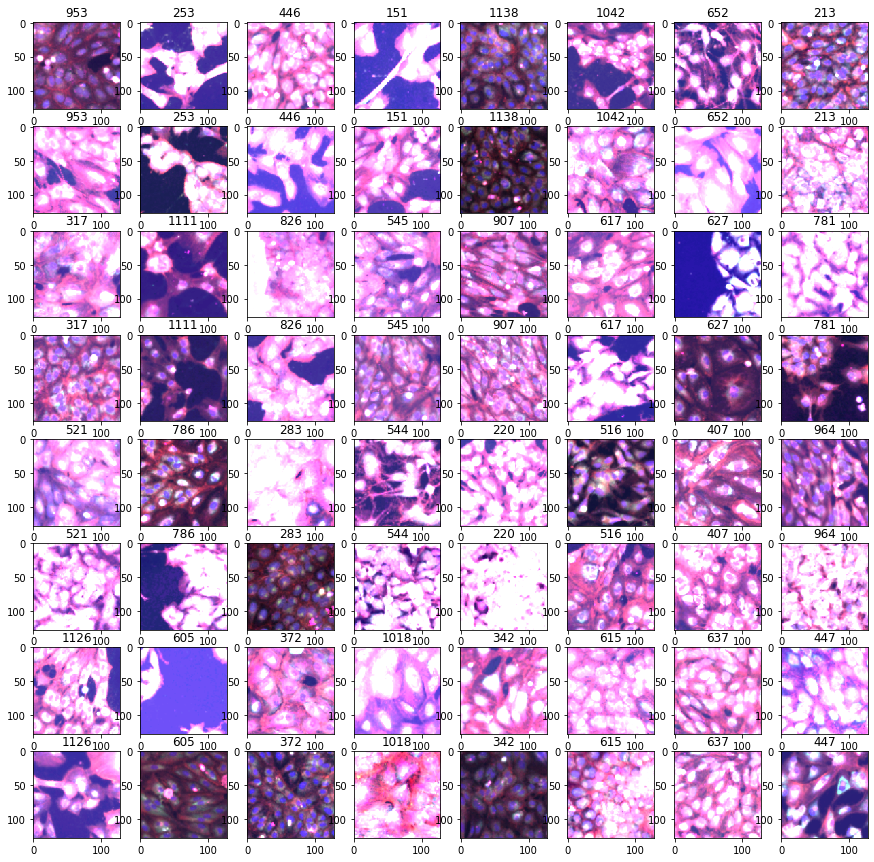

In [7]:
from dataset_generator import show_siamese_batch
show_siamese_batch(loaders_siam["train"])    
# (loaders["valid"])

In [3]:
from dataset_generator import create_predict_datasets_and_loaders
data = preprocess_data.rxrx_all()
datasets_pred, loaders_pred = create_predict_datasets_and_loaders(data, settings_model.batch_size, 
                                                          settings_model.basepath_data, 
                                                          settings_model.original_image_size)

Loading metadata...
Metadata shape: (125510, 10)
81224 values in ids_train
81224 values in labels_train
24 values in ids_train_debug
24 values in labels_train_debug
4492 values in ids_valid
4492 values in labels_valid
24 values in ids_valid_debug
24 values in labels_valid_debug
39794 values in ids_test
39794 values in labels_test
Total ids: 125558.0
Calculating normalization factors by experiment...


Image batch size: torch.Size([24, 6, 256, 256]). Label batch size: 24.
Average pixel value in batch: -0.00454
Stddev pixel value in batch: 1.19343


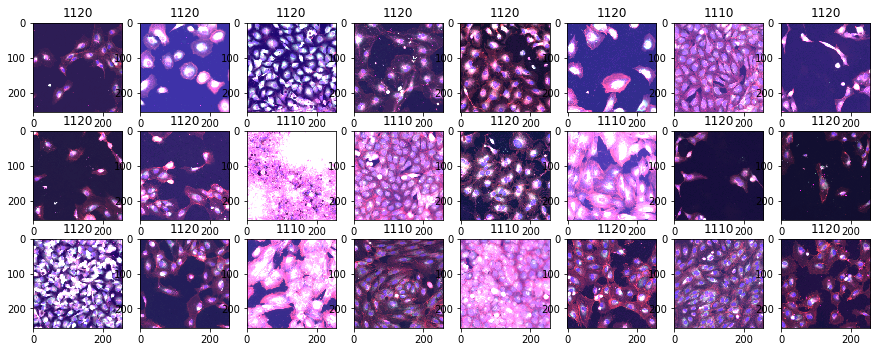

In [9]:
from dataset_generator import show_predict_batch
# show_predict_batch(loaders["train"])    
# show_predict_batch(loaders["valid"])    
show_predict_batch(loaders_pred["train_debug"])    


In [4]:
import torch
import os
from train_predict import predict
from architectures.siamese_resnet import siamese_resnet18, siamese_resnet50, siamese_resnet101
from architectures.siamese_efficientnet import SiameseEfficientNet

model_id = "HEPG2_20190805_185304"
output_model_dir = f"/jet/prs/workspace/models/siamese-cell/{model_id}"

# model = siamese_resnet50(pretrained=False, embedding_size=128).cuda()
model = SiameseEfficientNet.from_pretrained('efficientnet-b0').cuda()
checkpoint_path = os.path.join(output_model_dir, "loss.best.pth.tar")
checkpoint = torch.load(checkpoint_path)
pretrained_dict = checkpoint['state_dict']
model.load_state_dict(pretrained_dict)


GlobalParams(batch_norm_momentum=0.99, batch_norm_epsilon=0.001, dropout_rate=0.2, num_classes=1000, width_coefficient=1.0, depth_coefficient=1.0, depth_divisor=8, min_depth=None, drop_connect_rate=0.2, image_size=224)
Loaded pretrained weights for efficientnet-b0


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:
# predict(model, loaders_pred["train"], loaders_pred["valid"], mode="valid")

100%|██████████| 31/31 [00:06<00:00,  5.77it/s]

- Accuracy (method 2) at test time: 0.01814516129032257
- Accuracy (method 2) at test time: 0.0020161290322580645


In [30]:
from train_predict import filter_soft_hard_pairs
data = filter_soft_hard_pairs(model, next(iter(loaders_pred["train"])))

RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 5 and 4 at /pytorch/aten/src/TH/generic/THTensor.cpp:702

In [34]:
t1 = torch.tensor(np.zeros((6,128,128)))
t2 = torch.stack([t1,t1])
t2.size()

torch.Size([2, 6, 128, 128])

In [35]:
torch.stack([t1,t2])

RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 4 and 5 at /pytorch/aten/src/TH/generic/THTensor.cpp:702